In [559]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score
from torchinfo import summary
import time

In [560]:
# Load data
df = pd.read_csv('dataset.csv')

OBSERVE HISTPLOT TO CHECK IF THERE's ANY NOISE PRESENT IN THE COLUMNS

<Axes: xlabel='f1', ylabel='Count'>

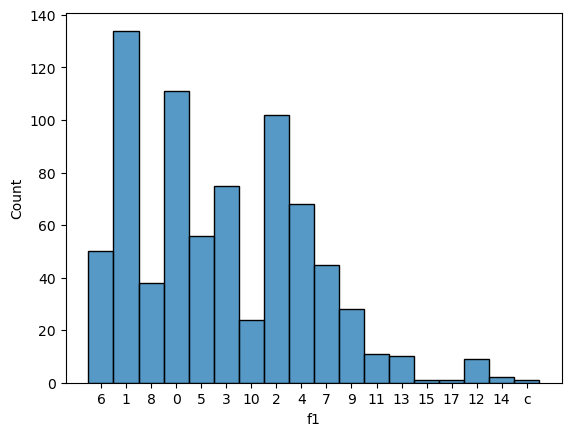

In [561]:
sns.histplot(data=df, x='f1')

In [562]:
#changing datatypes of numerical columns
for c in df.columns:
    if df[c].dtype=="object":
        df[c]=pd.to_numeric(df[c],errors='coerce')
df.fillna(df.median(),inplace=True)

In the hisplot above, we can observe alphabet c is present, which should not be belonging to this feature as it's a numerical column

MAIN STATISTICS OF THE DATASET

In [563]:
df.describe()

f1          f2          f3          f4          f5          f6  \
count  766.000000  766.000000  766.000000  766.000000  766.000000  766.000000   
mean     3.848564  120.904700   69.118799   20.545692   80.033943   31.998172   
std      3.371630   31.927369   19.376901   15.950327  115.309955    7.893111   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   62.500000    0.000000    0.000000   27.300000   
50%      3.000000  117.000000   72.000000   23.000000   36.000000   32.000000   
75%      6.000000  140.000000   80.000000   32.000000  127.750000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

               f7      target  
count  766.000000  766.000000  
mean     0.472000    0.349869  
std      0.331347    0.477240  
min      0.078000    0.000000  
25%      0.244000    0.000000  
50%      0.374000    0.000000  
75%      0.625500    1.000000  
max      2.420000    1.000000

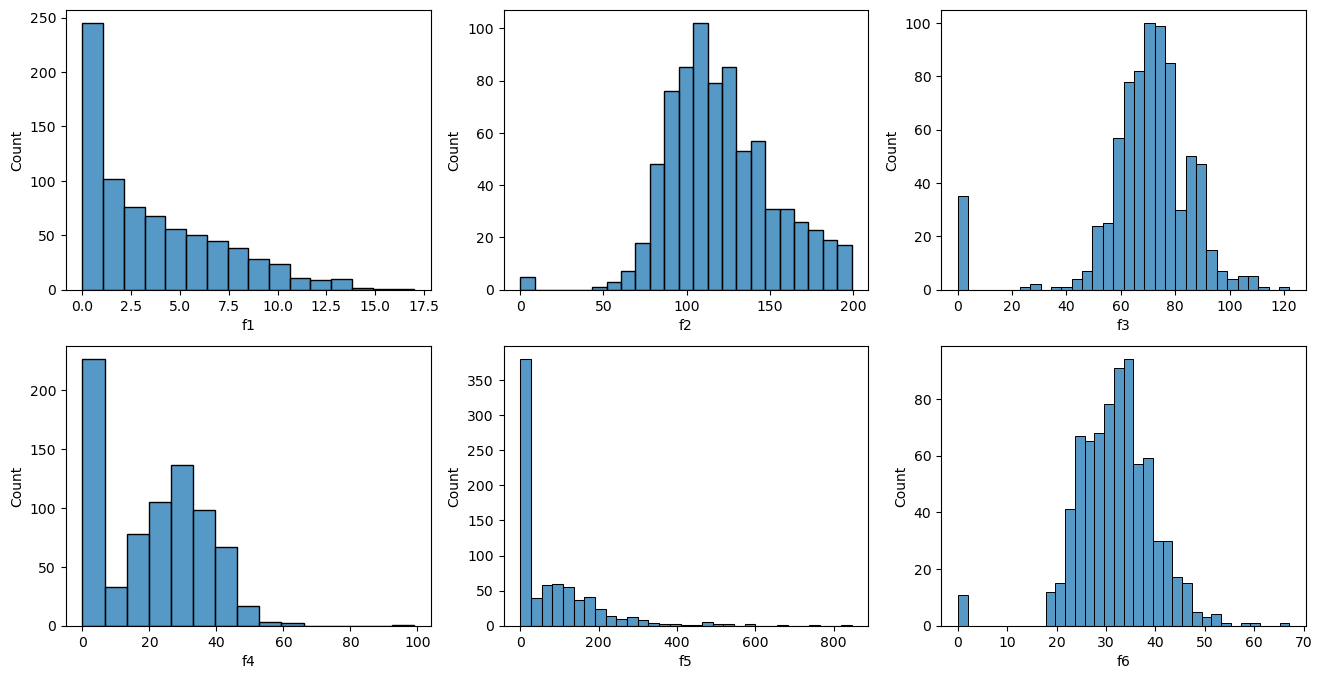

In [564]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
column = 0
for r in range(2):
    for c in range(3):
        sns.histplot(data=df, x=df.columns[column], ax=ax[r][c])
        column += 1

<Axes: >

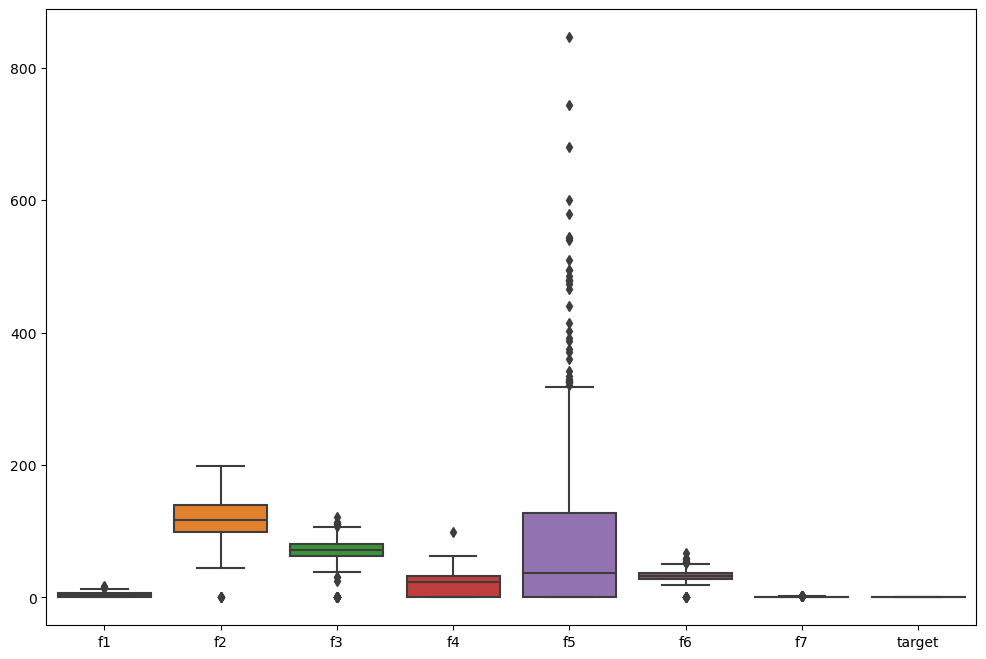

In [565]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df)

In [566]:
for col in df.select_dtypes(['float','int']).drop('target',axis=1).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    df.loc[(df[col] < lower_limit)|(df[col] > upper_limit), col] = df[col].median()

<Axes: >

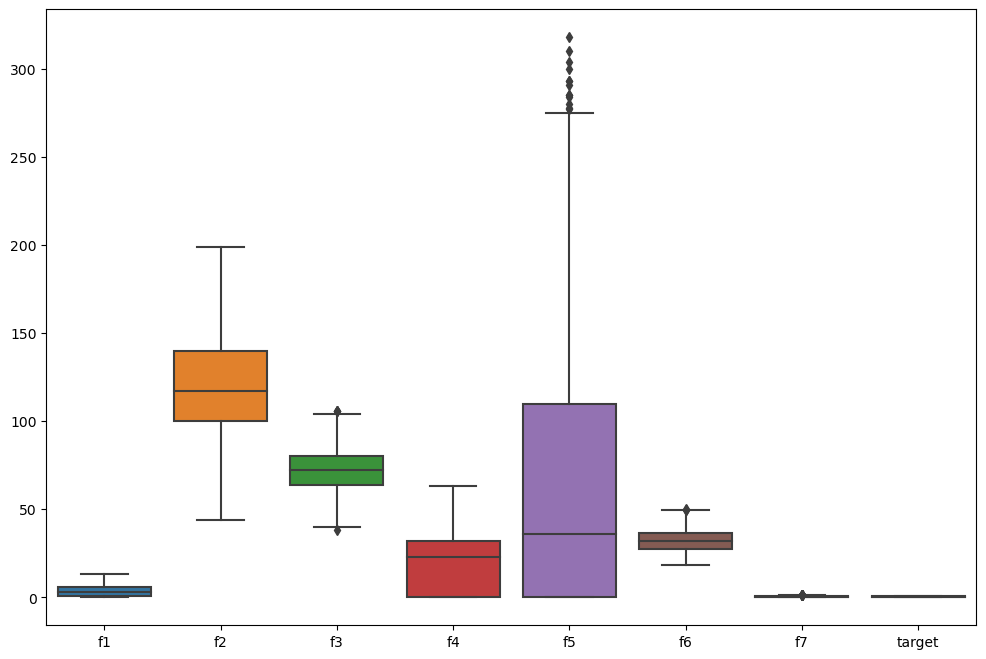

In [567]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df)

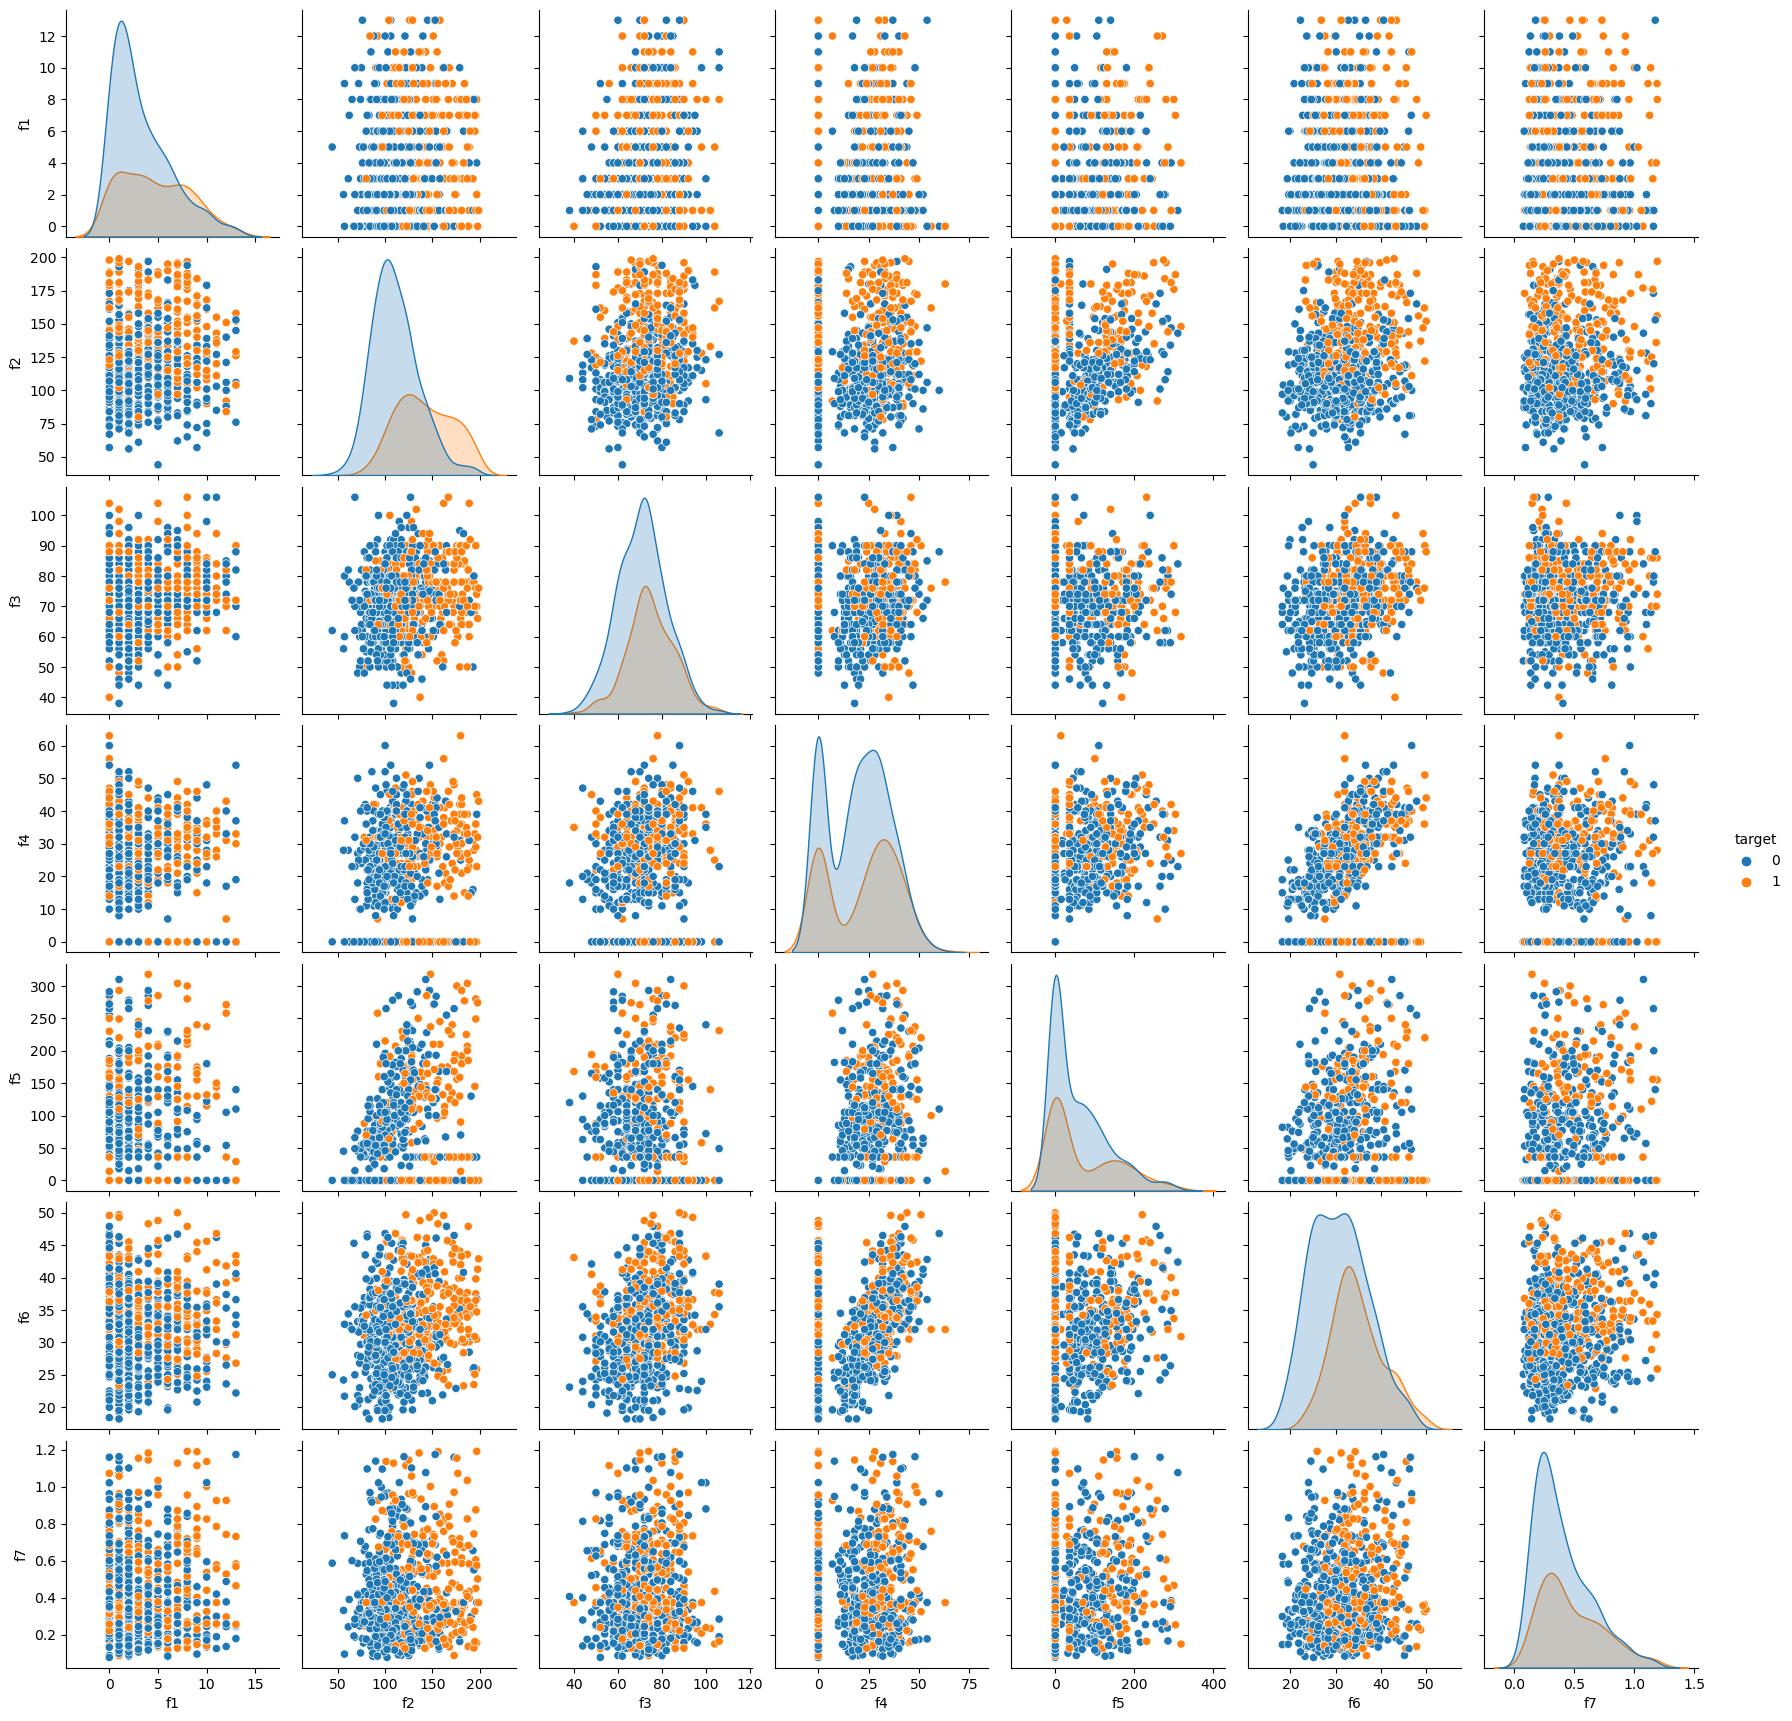

In [568]:
sns.pairplot(data=df, hue='target')

<Axes: xlabel='target', ylabel='count'>

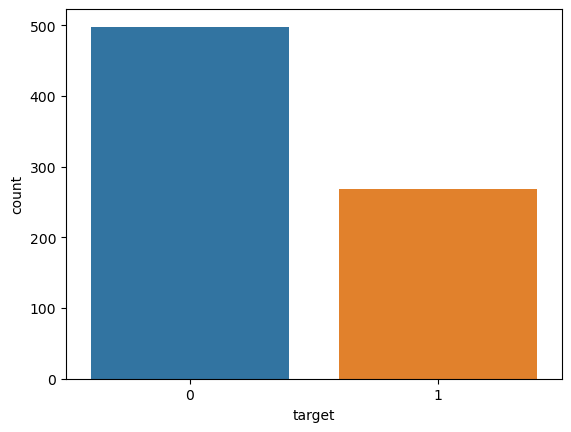

In [569]:
# Target distribution
sns.countplot(data=df, x = 'target')

<h4>Splitting and scaling the dataset</h4>

In [570]:
X = df.drop('target', axis=1).values
y = df['target'].values

!pip install imbalanced-learn
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [571]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Converting split datasets into torch tensors

In [572]:
batch_size = 32
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1) 
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

Defining Neural Network for part 1

In [573]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(NeuralNetwork, self).__init__()
        self.linearArchitecture = nn.Sequential(
        nn.Linear(input_size, hidden_size1),

        nn.ReLU(),
        nn.Dropout(0.31818687426066966),
        nn.Linear(hidden_size1, hidden_size2),

        nn.ReLU(),
        nn.Dropout(0.31818687426066966),
        nn.Linear(hidden_size2, 1, bias=True),
        nn.Sigmoid()
        )

    def forward(self, x):
        return self.linearArchitecture(x)
    
    def summary(self, input_size, batch_size):
        return summary(model, input_size=(batch_size, input_size))
# Instantiate the model
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64

model = NeuralNetwork(input_size, hidden_size1, hidden_size2)

Summary of the neural network model

In [574]:
model.summary(input_size, batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Linear: 2-1                       [32, 128]                 1,024
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Dropout: 2-3                      [32, 128]                 --
│    └─Linear: 2-4                       [32, 64]                  8,256
│    └─ReLU: 2-5                         [32, 64]                  --
│    └─Dropout: 2-6                      [32, 64]                  --
│    └─Linear: 2-7                       [32, 1]                   65
│    └─Sigmoid: 2-8                      [32, 1]                   --
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.30
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.04
Estimated Total Size (MB): 0

Defining the criterion and optimizer for our model

In [575]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Defining the training loop with 100 epochs

In [576]:
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i + batch_size]
        labels = y_train_tensor[i:i + batch_size]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_accuracy = ((val_outputs > 0.5).float() == y_val_tensor).sum().item() / y_val_tensor.size(0)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(accuracy_score(y_train, (model(X_train_tensor).detach().numpy() > 0.5).astype(int)))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, 'f'Validation Accuracy: {val_accuracy * 100:.2f}%')

end_time = time.time()
print(f'Time taken by the NN model to train (in seconds): {end_time - start_time:.2f} seconds')

Epoch 1, Train Loss: 0.6890, Validation Loss: 0.6711, Validation Accuracy: 60.40%
Epoch 2, Train Loss: 0.6553, Validation Loss: 0.6626, Validation Accuracy: 69.80%
Epoch 3, Train Loss: 0.6427, Validation Loss: 0.6536, Validation Accuracy: 73.83%
Epoch 4, Train Loss: 0.6381, Validation Loss: 0.6449, Validation Accuracy: 75.84%
Epoch 5, Train Loss: 0.6210, Validation Loss: 0.6356, Validation Accuracy: 75.84%
Epoch 6, Train Loss: 0.6258, Validation Loss: 0.6264, Validation Accuracy: 75.84%
Epoch 7, Train Loss: 0.5985, Validation Loss: 0.6170, Validation Accuracy: 75.84%
Epoch 8, Train Loss: 0.5962, Validation Loss: 0.6074, Validation Accuracy: 75.17%
Epoch 9, Train Loss: 0.5706, Validation Loss: 0.5967, Validation Accuracy: 76.51%
Epoch 10, Train Loss: 0.5642, Validation Loss: 0.5861, Validation Accuracy: 76.51%
Epoch 11, Train Loss: 0.5759, Validation Loss: 0.5760, Validation Accuracy: 77.85%
Epoch 12, Train Loss: 0.5497, Validation Loss: 0.5660, Validation Accuracy: 76.51%
Epoch 13, Tra

In [577]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = (test_outputs > 0.5).float()
    test_loss = criterion(test_outputs, y_test_tensor)
    test_accuracy = (test_predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, test_predictions, average='binary')
    roc_auc = roc_auc_score(y_test, test_predictions)

print(f'ROC: {roc_auc:.2f}')
print(f'Test Loss: {test_loss:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')

ROC: 0.77
Test Loss: 0.50
Recall: 0.76
Test Accuracy: 76.67%
Precision: 0.73
F1 Score: 0.75


In [578]:
torch.save(model.state_dict(), 'cnara_dharmaac_assignment2_part1.h5')

In [579]:
def print_confusion_matrix(y_test, test_predictions):
    matrix = confusion_matrix(y_test, test_predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def print_ROC_Curve(y_test, test_predictions):
    fpr, tpr, thresholds = roc_curve(y_test, test_predictions.numpy())
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC={roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def print_accuracy_graph(train_accuracies, val_accuracies, num_epochs=100):
    plt.figure(figsize=(8,6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
    plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
    plt.xlabel('No of Epochs')
    plt.ylabel('Accuracies')
    plt.title('Accuracies for Train, Test and Validation')
    plt.legend()
    plt.show()

def print_loss_graph(train_losses, val_losses, num_epochs=100):
    plt.figure(figsize=(8, 6))
    epochs_range = range(1, num_epochs + 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses for Train, Test and Validation')
    plt.legend()

# print_confusion_matrix(y_test, test_predictions)
# print_loss_graph(train_losses, val_losses)
# print_ROC_Curve(y_test, test_predictions)
# print_accuracy_graph(train_accuracies, val_accuracies)


Confusion Matrix

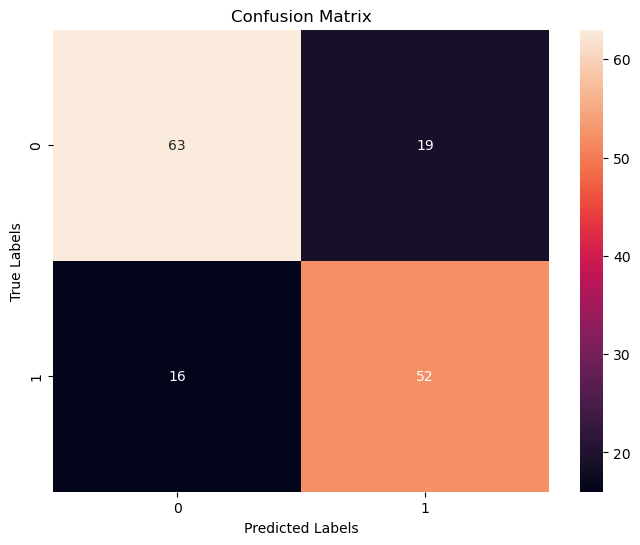

In [580]:
print_confusion_matrix(y_test, test_predictions)

Loss Graph

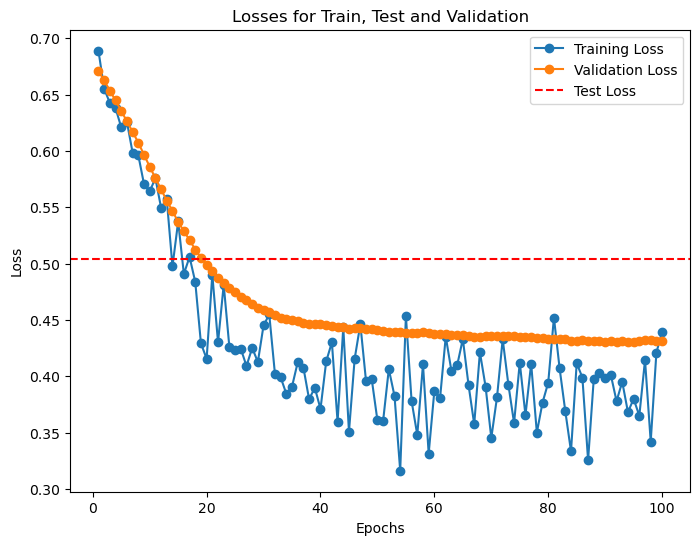

In [581]:
print_loss_graph(train_losses, val_losses)

ROC Curve

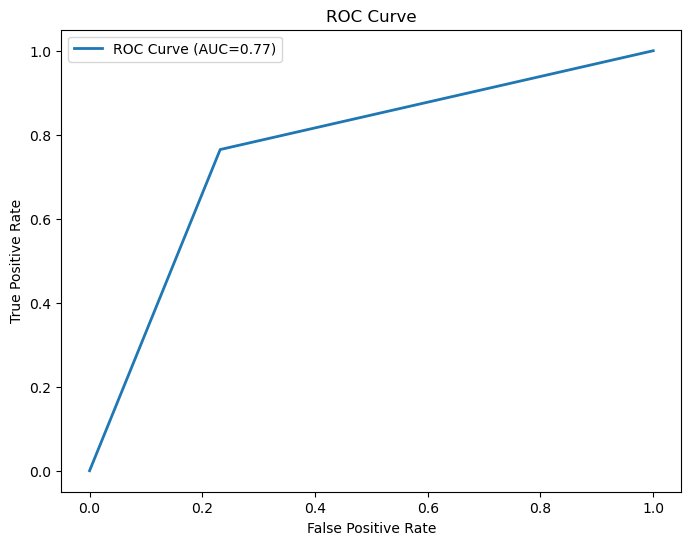

In [582]:
print_ROC_Curve(y_test, test_predictions)

Accuracy Graph

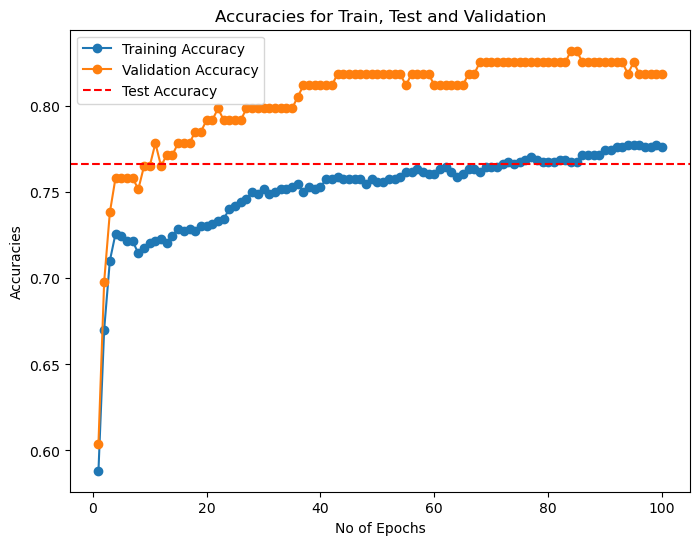

In [583]:
print_accuracy_graph(train_accuracies, val_accuracies)

Part II: Hyperparameter Tuning

In [584]:
# Defining Network
class TuningNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_rate, initializer_type='default'):
        super(TuningNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()
        if initializer_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        elif initializer_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        elif initializer_type == 'uniform':
            nn.init.uniform_(self.fc1.weight, -1, 1)
            nn.init.uniform_(self.fc2.weight, -1, 1)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.out(x)
        return self.sigmoid(x)
    
# Instantiate the model
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64


Training with Dropout Rate: 0.1
Time to train model: 1.63 seconds
ROC: 0.76
Test Loss: 0.57
Precision: 0.70
F1 Score: 0.75
Recall: 0.81
Test Accuracy: 75.33%


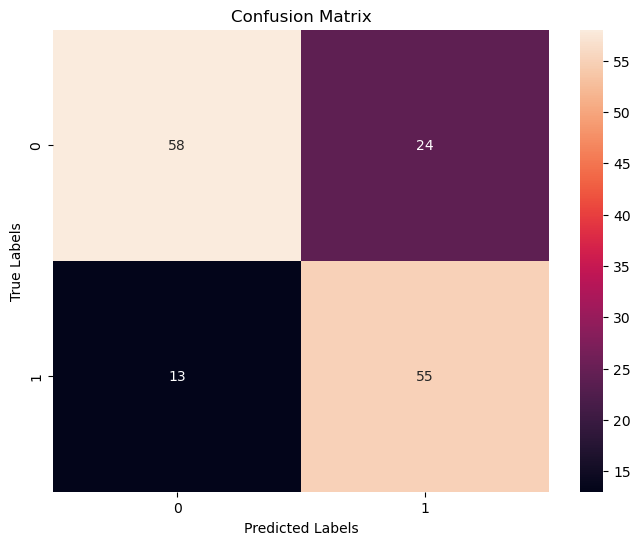

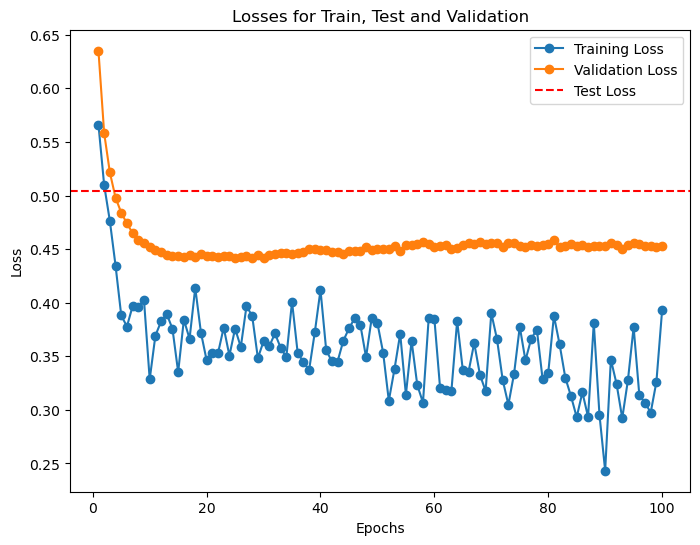

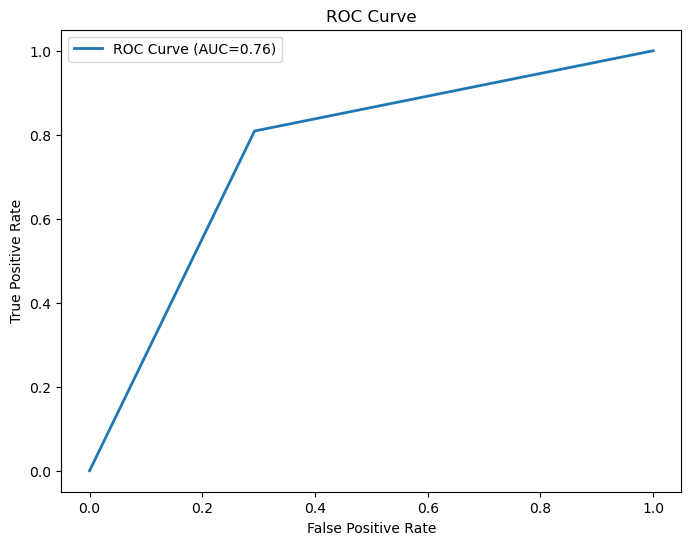

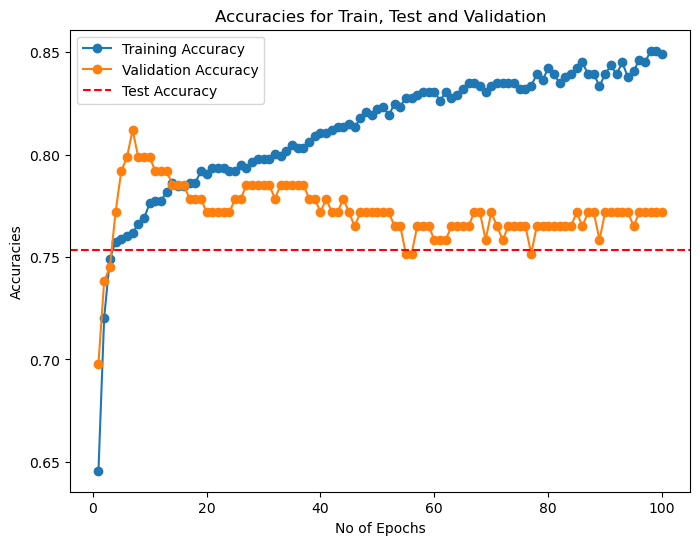


Training with Dropout Rate: 0.3
Time to train model: 1.24 seconds
ROC: 0.78
Test Loss: 0.53
Precision: 0.72
F1 Score: 0.76
Recall: 0.81
Test Accuracy: 77.33%


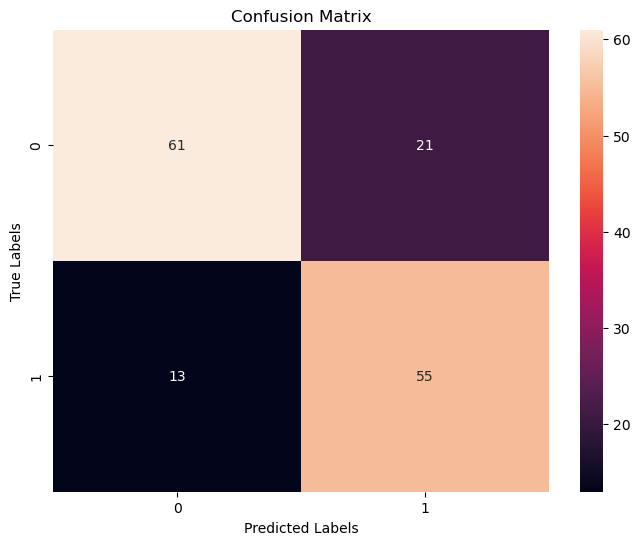

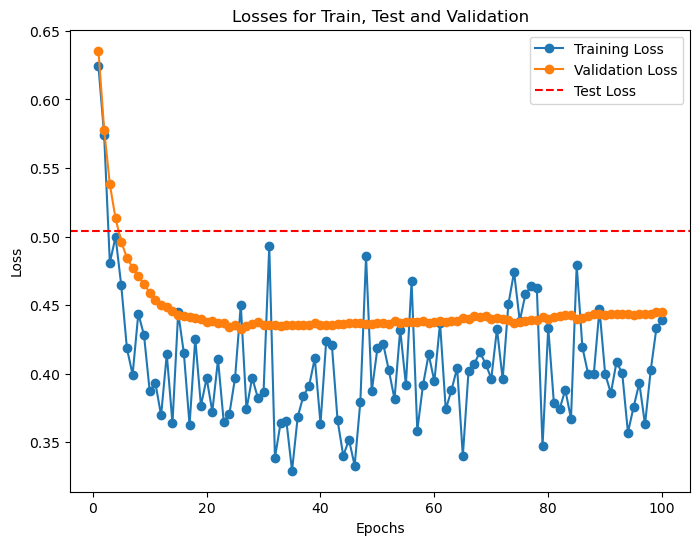

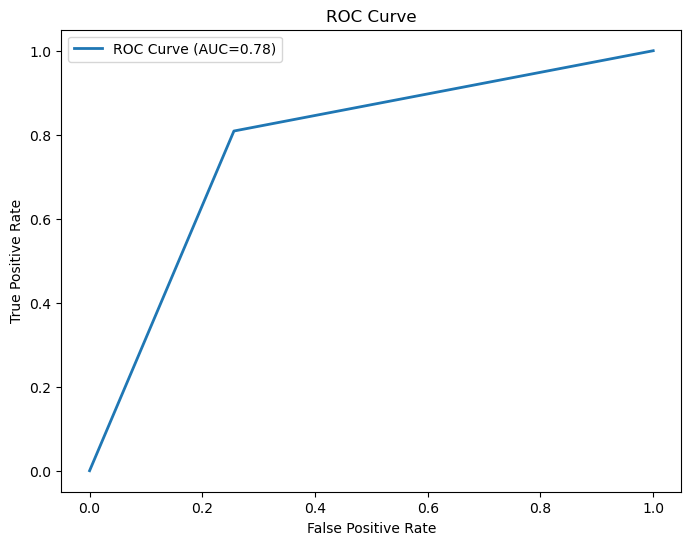

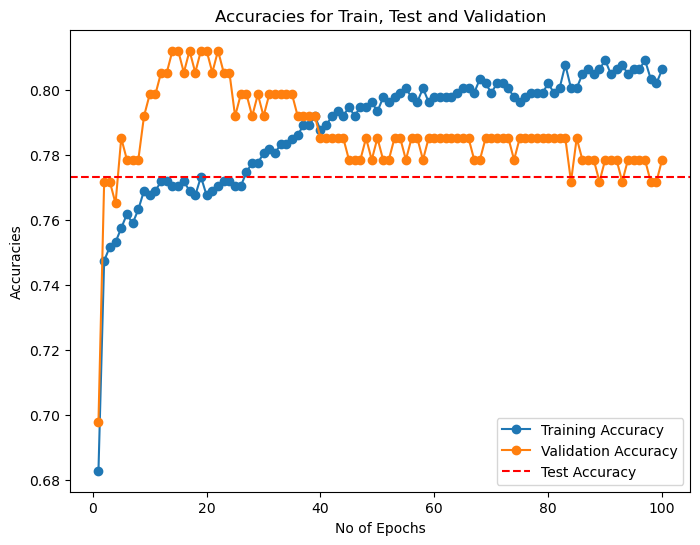


Training with Dropout Rate: 0.5
Time to train model: 1.47 seconds
ROC: 0.76
Test Loss: 0.51
Precision: 0.71
F1 Score: 0.75
Recall: 0.81
Test Accuracy: 76.00%


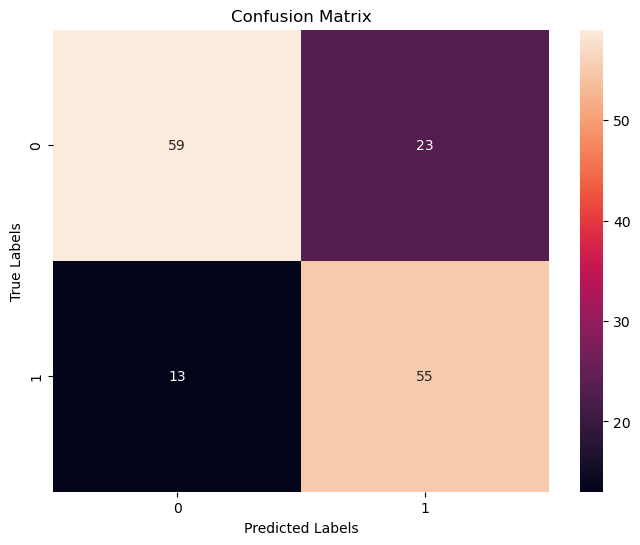

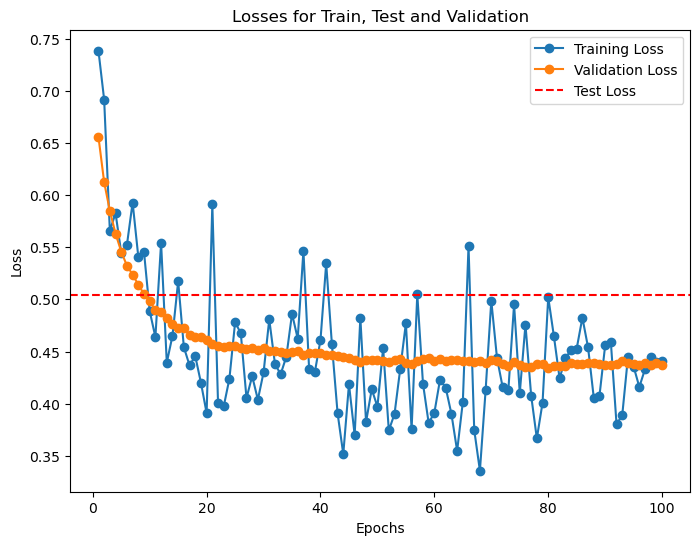

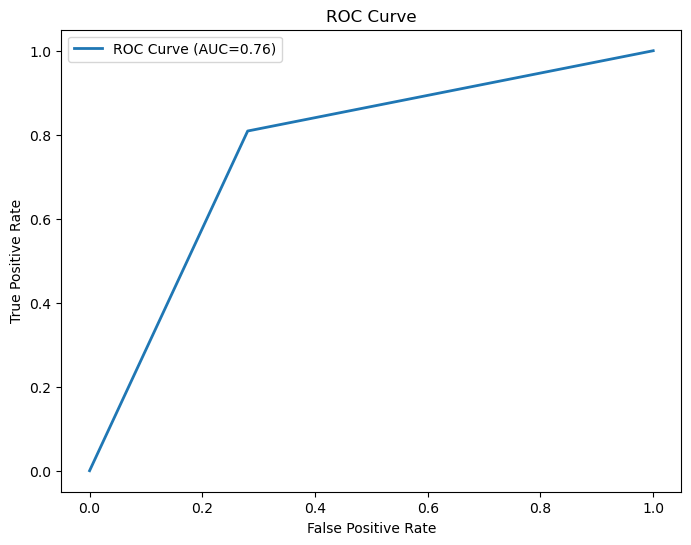

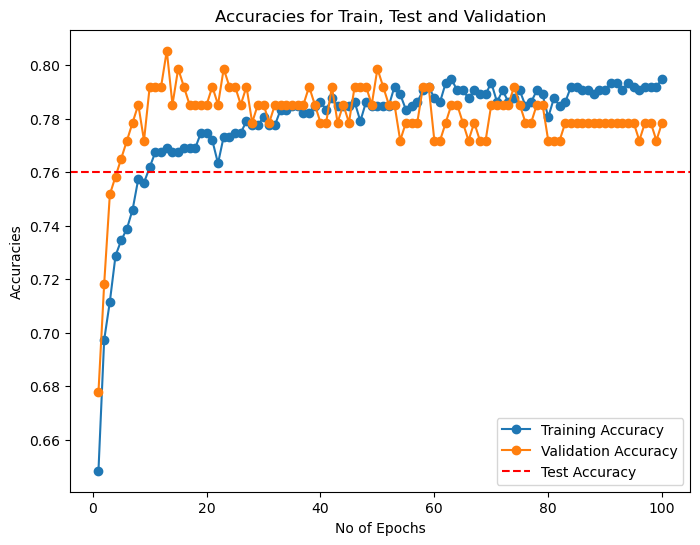


Training with Initializers : xavier
Time to train model: 1.58 seconds
ROC: 0.77
Test Loss: 0.50
Precision: 0.73
F1 Score: 0.75
Recall: 0.76
Test Accuracy: 76.67%


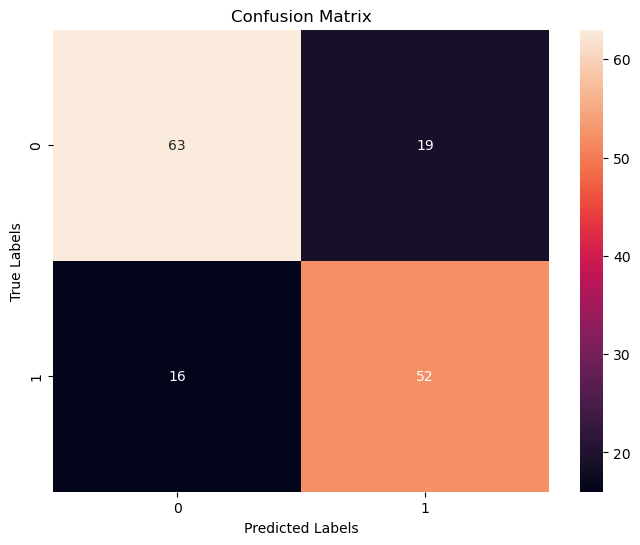

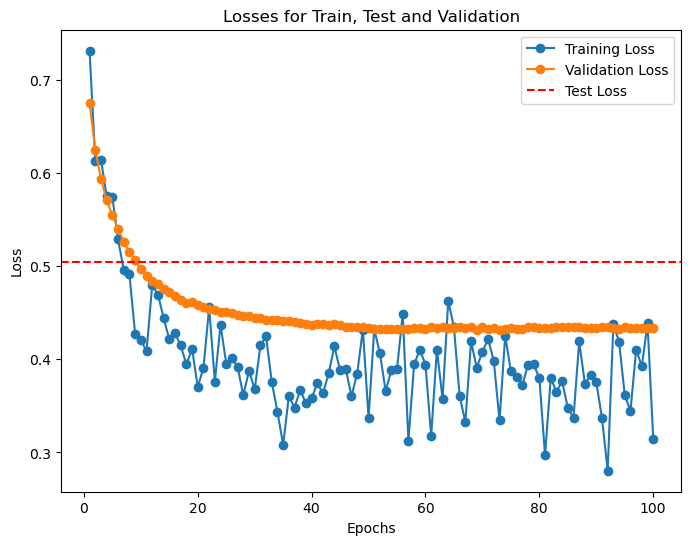

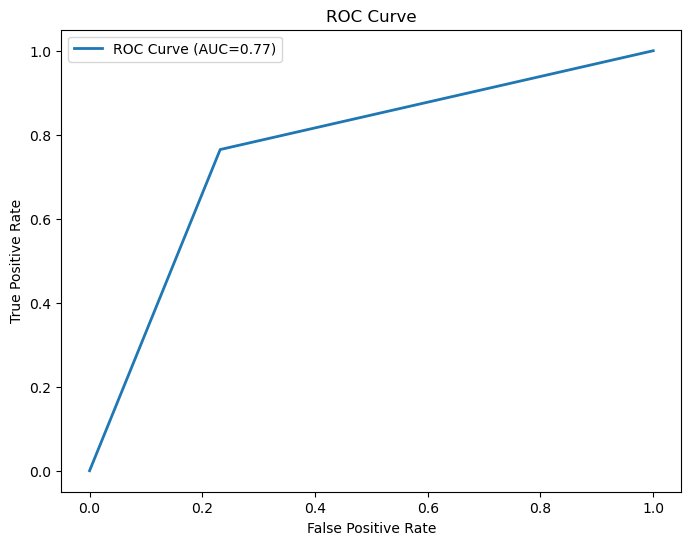

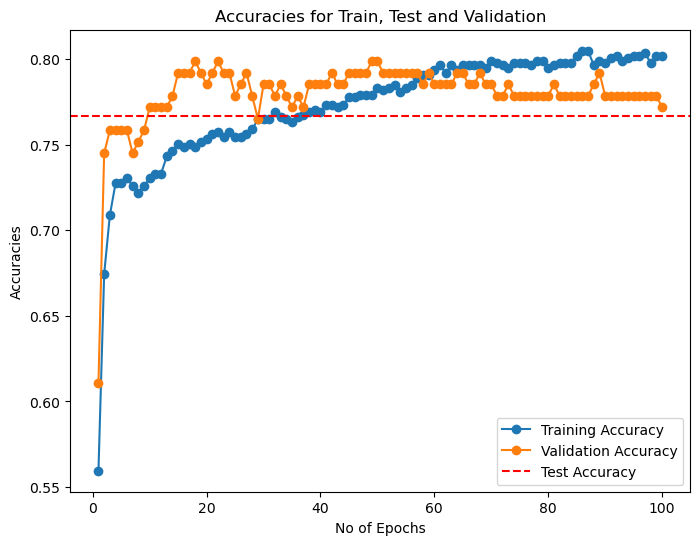


Training with Initializers : he
Time to train model: 1.67 seconds
ROC: 0.78
Test Loss: 0.50
Precision: 0.74
F1 Score: 0.77
Recall: 0.79
Test Accuracy: 78.00%


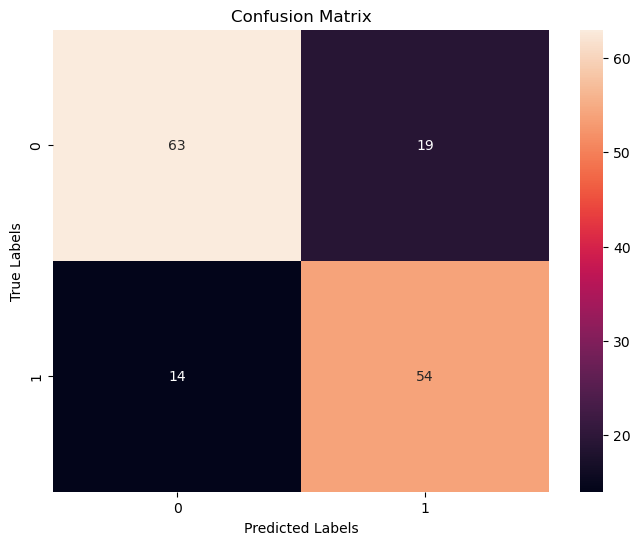

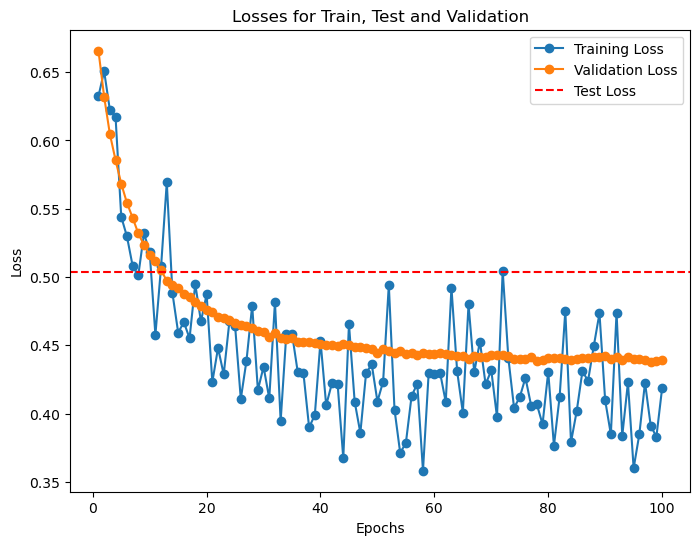

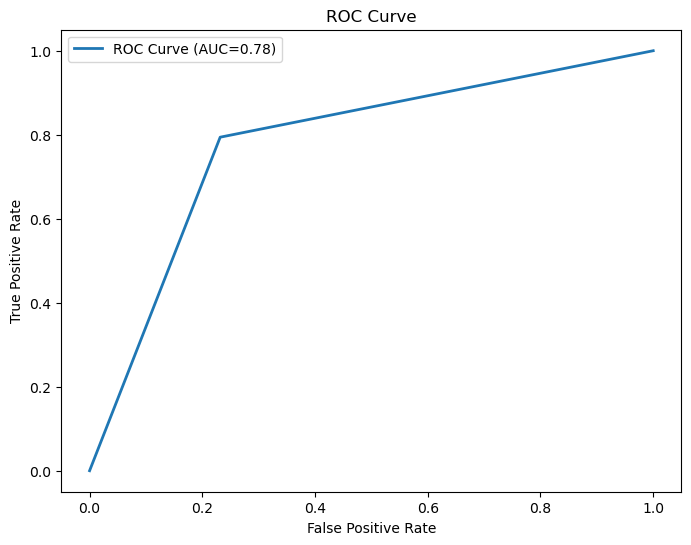

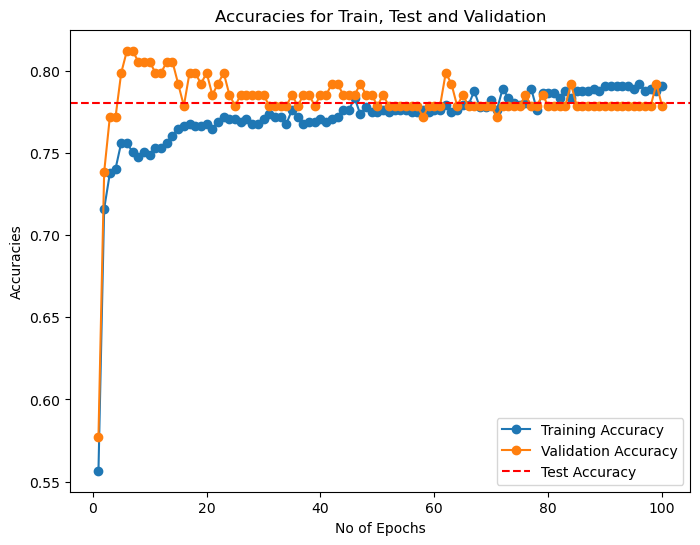


Training with Initializers : uniform
Time to train model: 1.55 seconds
ROC: 0.77
Test Loss: 0.50
Precision: 0.72
F1 Score: 0.76
Recall: 0.79
Test Accuracy: 76.67%


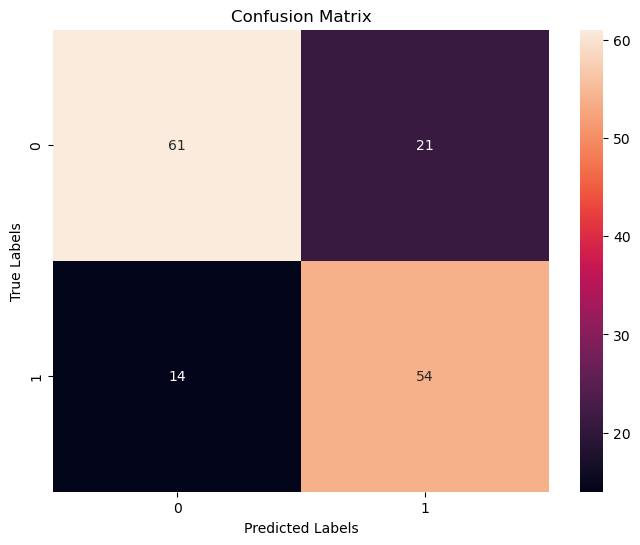

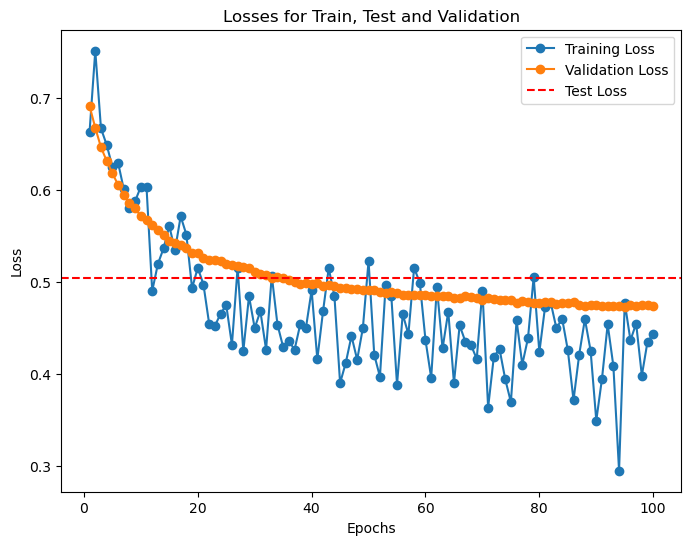

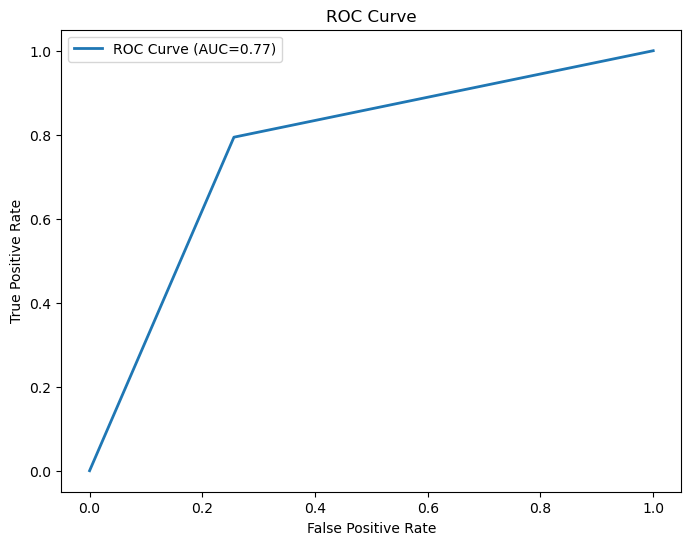

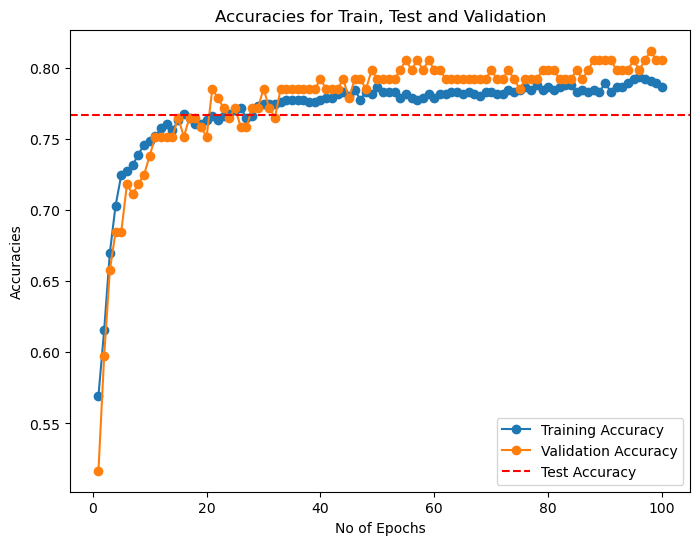


Training with Activation Function: ReLU
Time to train model: 2.04 seconds
ROC: 0.73
Test Loss: 0.84
Precision: 0.66
F1 Score: 0.73
Recall: 0.82
Test Accuracy: 72.67%


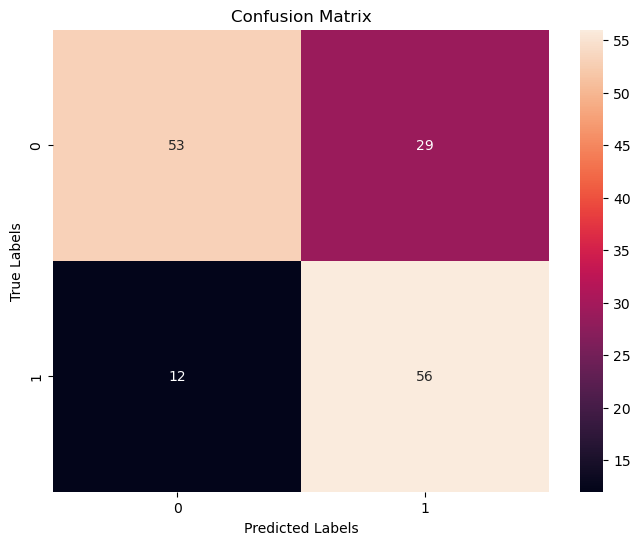

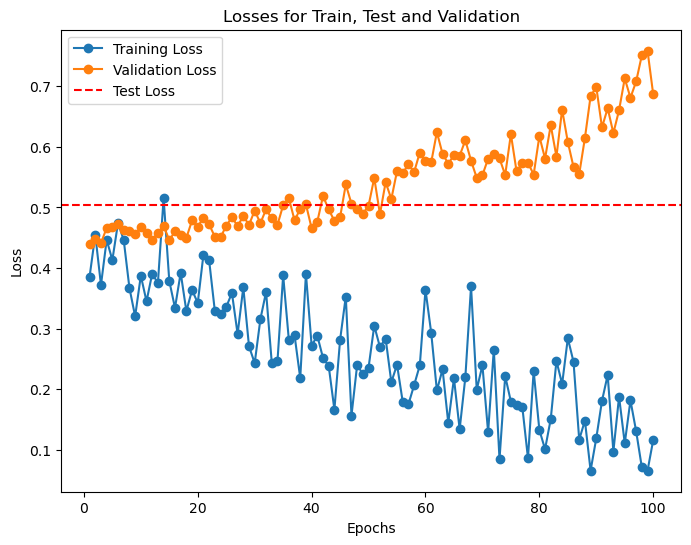

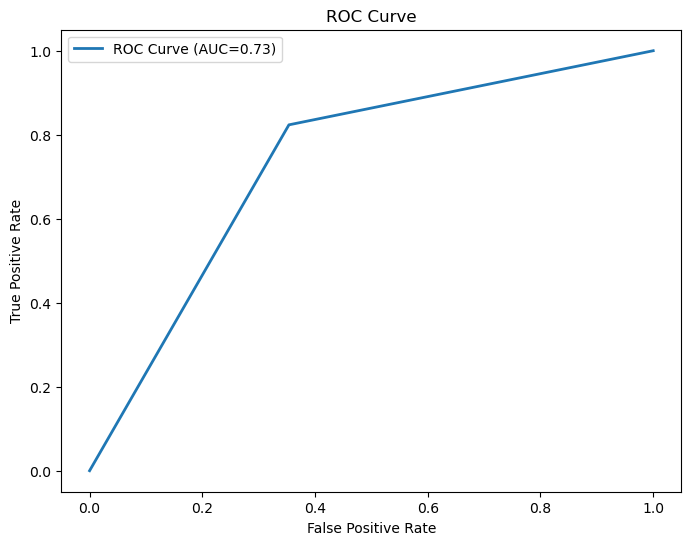

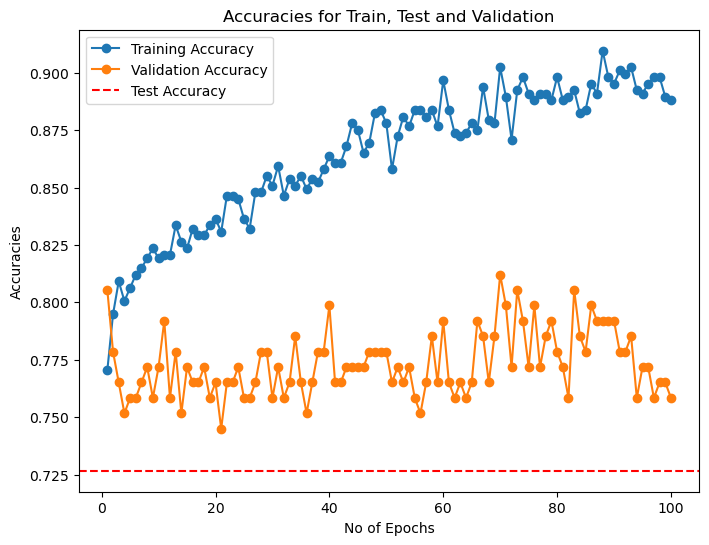


Training with Activation Function: LeakyReLU
Time to train model: 1.92 seconds
ROC: 0.74
Test Loss: 0.61
Precision: 0.68
F1 Score: 0.73
Recall: 0.78
Test Accuracy: 73.33%


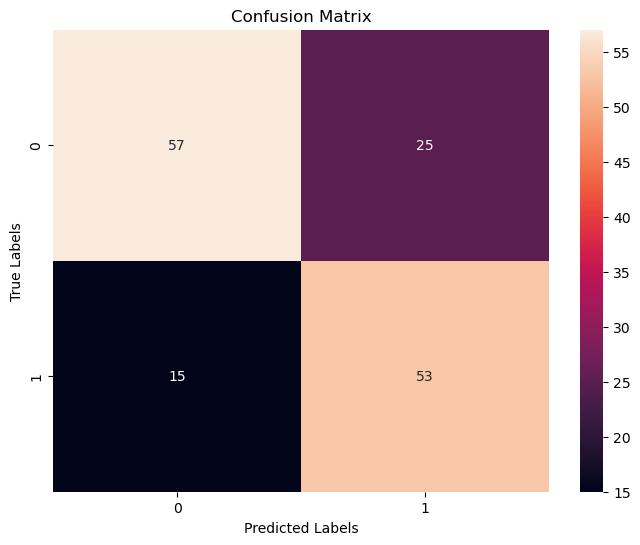

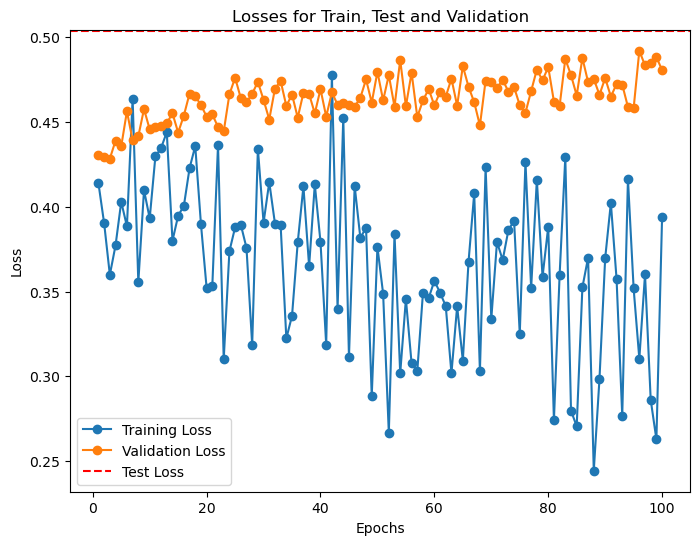

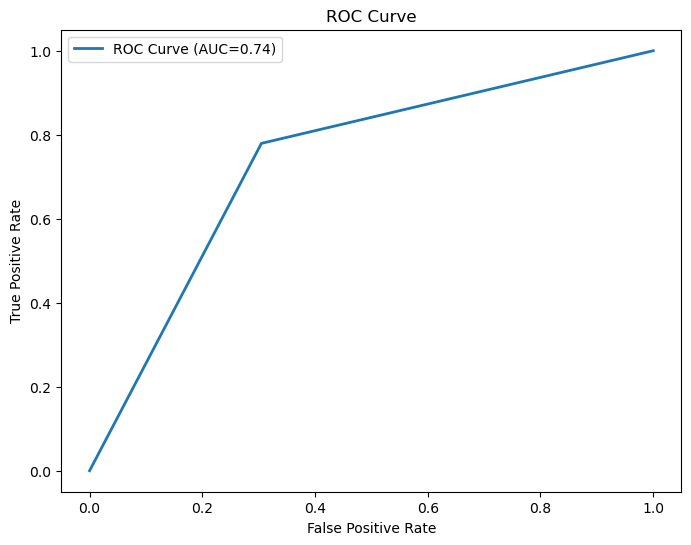

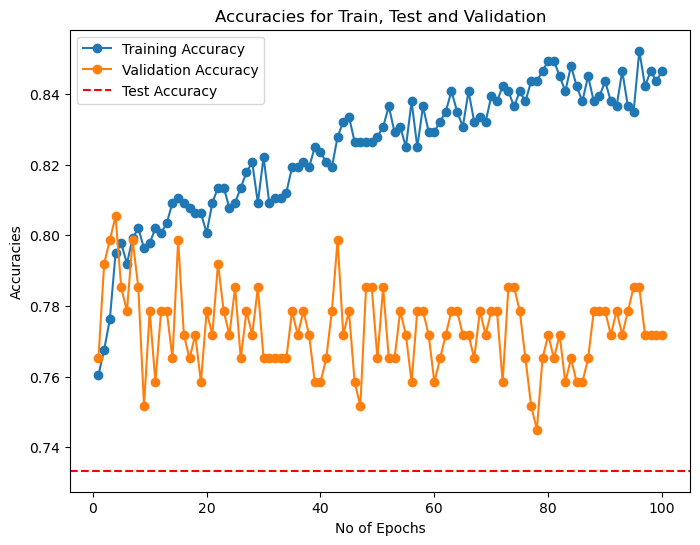


Training with Activation Function: ELU
Time to train model: 2.11 seconds
ROC: 0.76
Test Loss: 0.57
Precision: 0.71
F1 Score: 0.75
Recall: 0.79
Test Accuracy: 76.00%


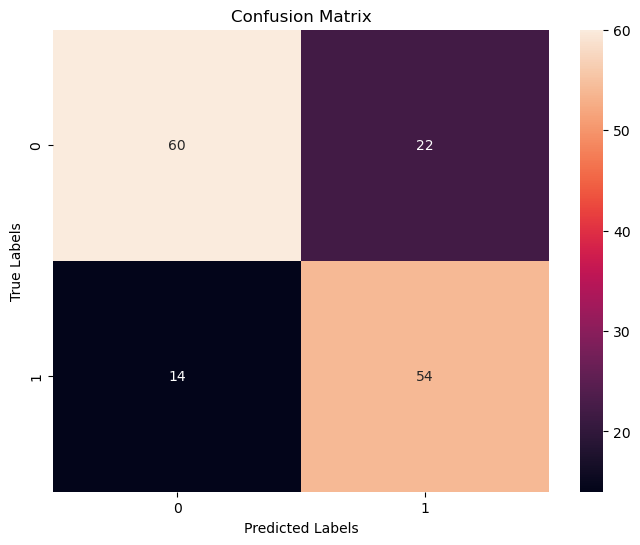

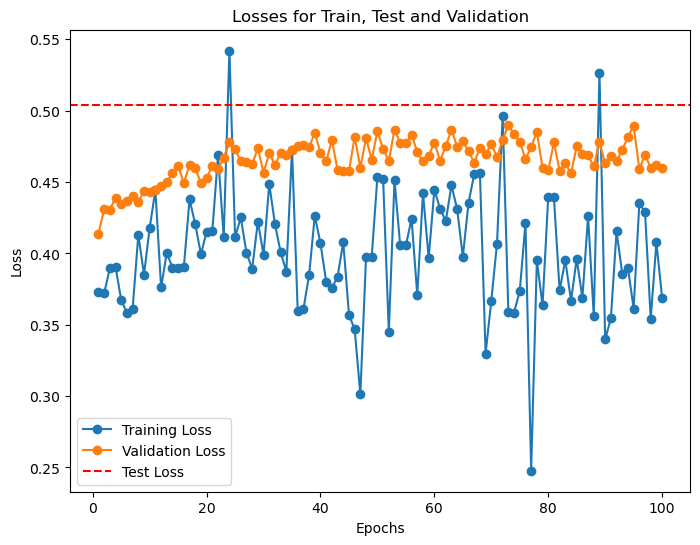

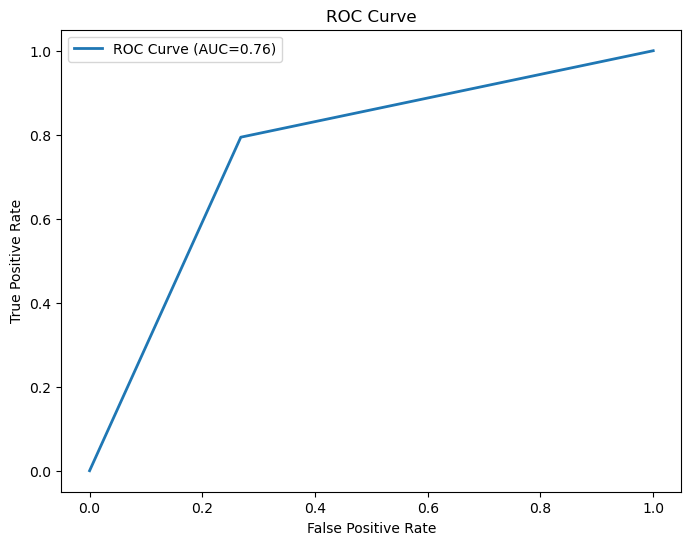

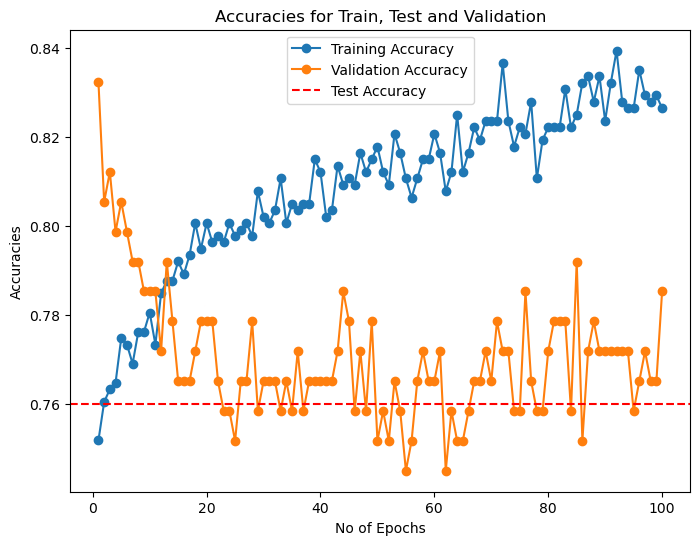

In [585]:
# Function to train and evaluate the model
def trainevalmethod(model, criterion, optimizer, num_epochs=100, batch_size=32):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    start_time = time.time()
    for epoch in range(num_epochs):
        # Training Step
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i + batch_size]
            labels = y_train_tensor[i:i + batch_size]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # Validation Step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            val_accuracy = ((val_outputs > 0.5).float() == y_val_tensor).sum().item() / y_val_tensor.size(0)
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(accuracy_score(y_train, (model(X_train_tensor).detach().numpy() > 0.5).astype(int)))
        val_accuracies.append(val_accuracy)
    end_time = time.time()
    print(f'Time to train model: {end_time - start_time:.2f} seconds')
    # Testing step
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_predictions = (test_outputs > 0.5).float()
        test_accuracy = accuracy_score(y_test, test_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, test_predictions, average='binary')
        roc_auc = roc_auc_score(y_test, test_predictions)
    print(f'ROC: {roc_auc:.2f}')
    print(f'Test Loss: {test_loss:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
    
   
    return train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions

# Hyperparameter Tuning
dropout_rates = [0.1, 0.3, 0.5]
initializers = ['xavier', 'he', 'uniform']
activation_functions = ['ReLU', 'LeakyReLU', 'ELU']

results = []

# Hyperparameter Tuning: Dropout Rate
for dropout_rate in dropout_rates:
    model = TuningNetwork(input_size, hidden_size1, hidden_size2, dropout_rate)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    print()
    print(f"Training with Dropout Rate: {dropout_rate}")
    train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions = trainevalmethod(model, criterion, optimizer)
    torch.save(model.state_dict(), f'dropout_model_{dropout_rate}.pth')

    print_confusion_matrix(y_test, test_predictions)
    print_loss_graph(train_losses, val_losses)
    print_ROC_Curve(y_test, test_predictions)
    print_accuracy_graph(train_accuracies, val_accuracies)

    
for initializer in initializers:
    model = TuningNetwork(input_size, hidden_size1, hidden_size2, 0.3, initializer)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    print()
    print(f"Training with Initializers : {initializer}")
    train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions = trainevalmethod(model, criterion, optimizer)
    
    print_confusion_matrix(y_test, test_predictions)
    print_loss_graph(train_losses, val_losses)
    print_ROC_Curve(y_test, test_predictions)
    print_accuracy_graph(train_accuracies, val_accuracies)

# Hyperparameter Tuning: Activation Function
for activation_function in activation_functions:
    if activation_function == 'ReLU':
        activation_func = nn.ReLU()
    elif activation_function == 'LeakyReLU':
        activation_func = nn.LeakyReLU(0.2)
    elif activation_function == 'ELU':
        activation_func = nn.ELU()

    model = TuningNetwork(input_size, hidden_size1, hidden_size2, 0.3)
    model.relu1 = activation_func
    model.relu2 = activation_func
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()

    print()
    print(f"Training with Activation Function: {activation_function}")
    train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions = trainevalmethod(model, criterion, optimizer)
    
    print_confusion_matrix(y_test, test_predictions)
    print_loss_graph(train_losses, val_losses)
    print_ROC_Curve(y_test, test_predictions)
    print_accuracy_graph(train_accuracies, val_accuracies)
    

TUNING OPTIMIZERS


Training with Optimizers : Adam
Time to train model: 2.05 seconds
ROC: 0.74
Test Loss: 1.00
Precision: 0.68
F1 Score: 0.73
Recall: 0.79
Test Accuracy: 73.33%


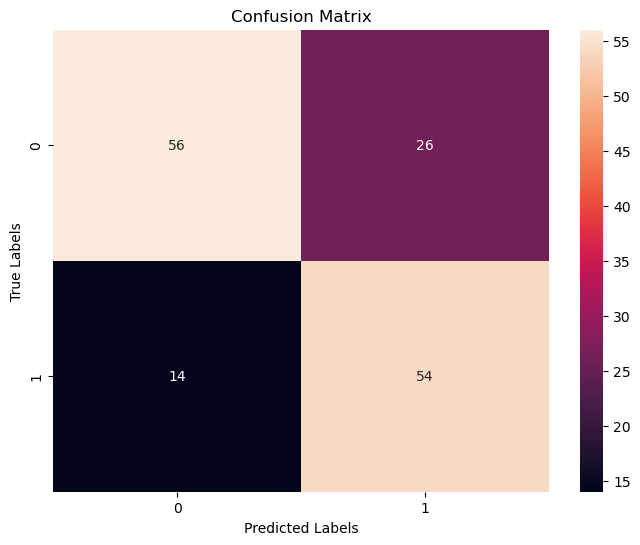

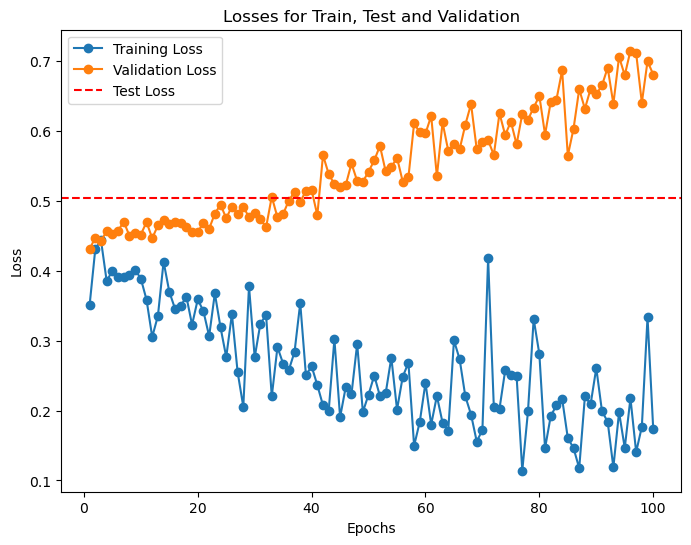

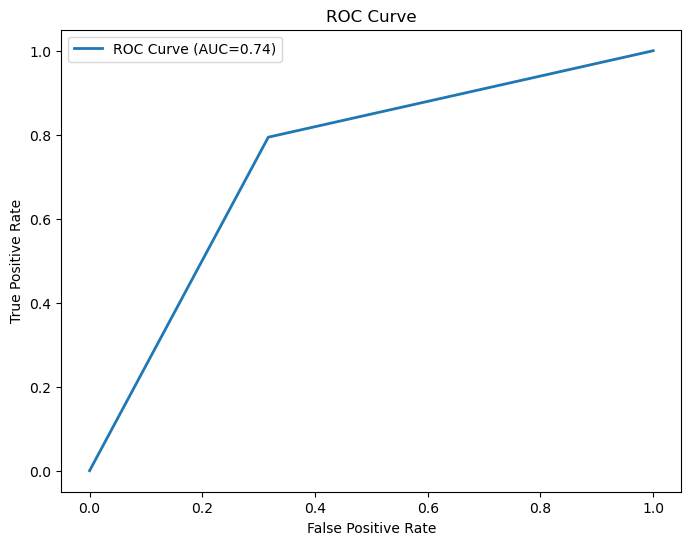

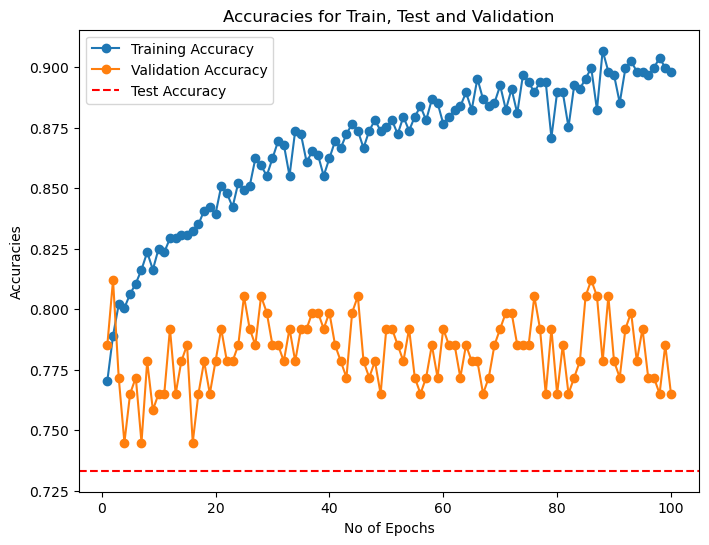


Training with Optimizers : Adamax
Time to train model: 1.98 seconds
ROC: 0.70
Test Loss: 0.72
Precision: 0.63
F1 Score: 0.69
Recall: 0.76
Test Accuracy: 69.33%


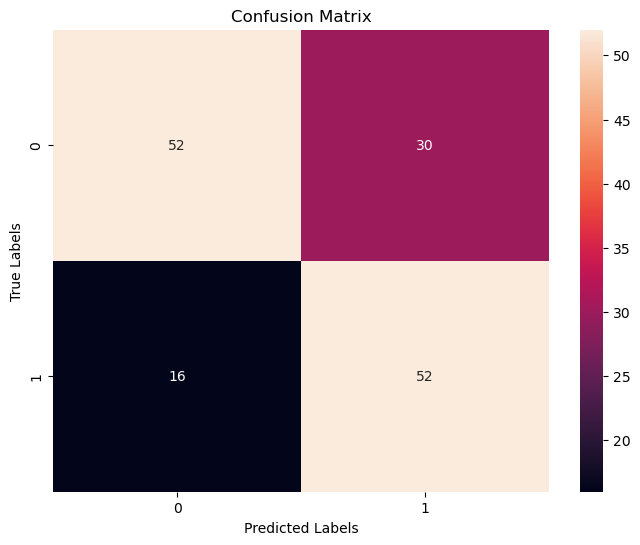

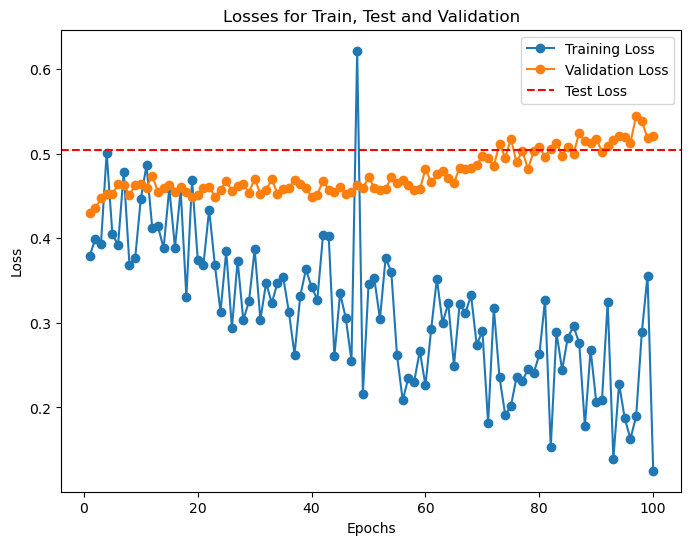

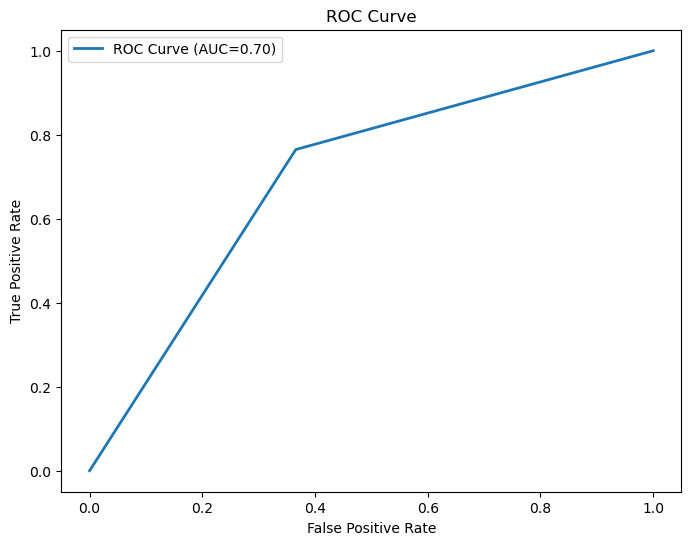

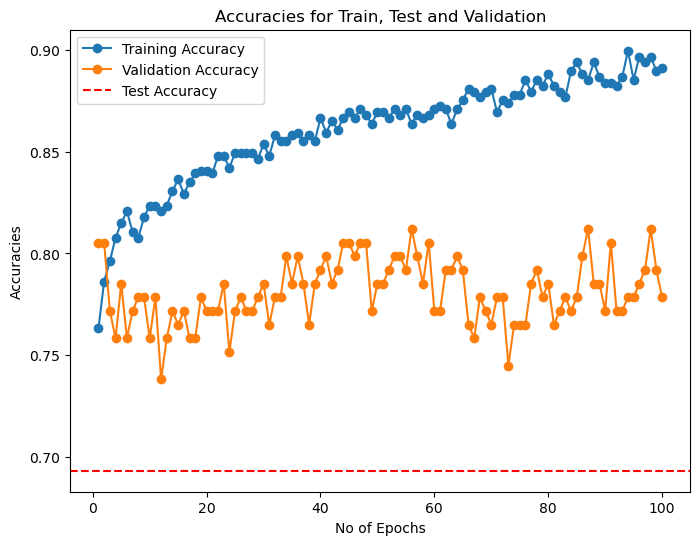


Training with Optimizers : RMSProp
Time to train model: 1.74 seconds
ROC: 0.75
Test Loss: 1.01
Precision: 0.68
F1 Score: 0.75
Recall: 0.84
Test Accuracy: 74.67%


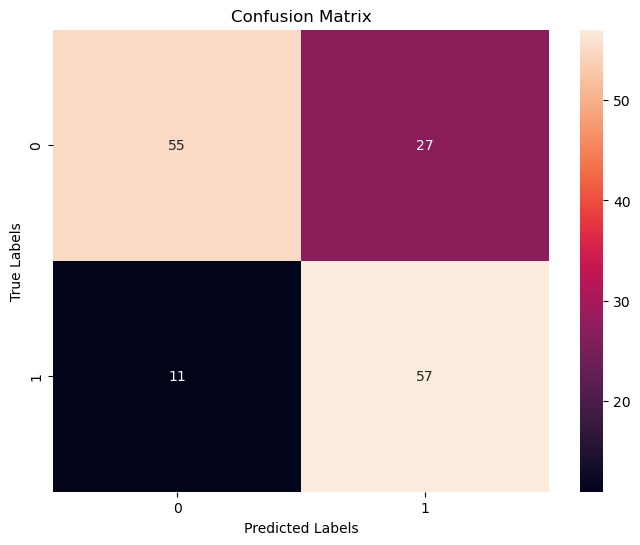

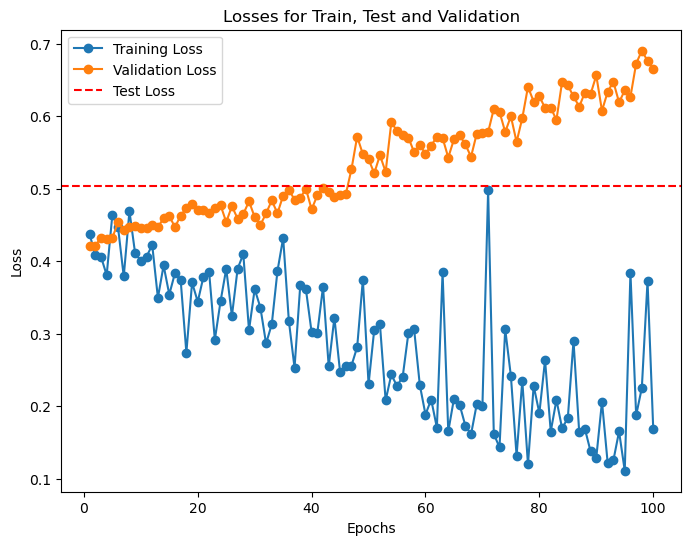

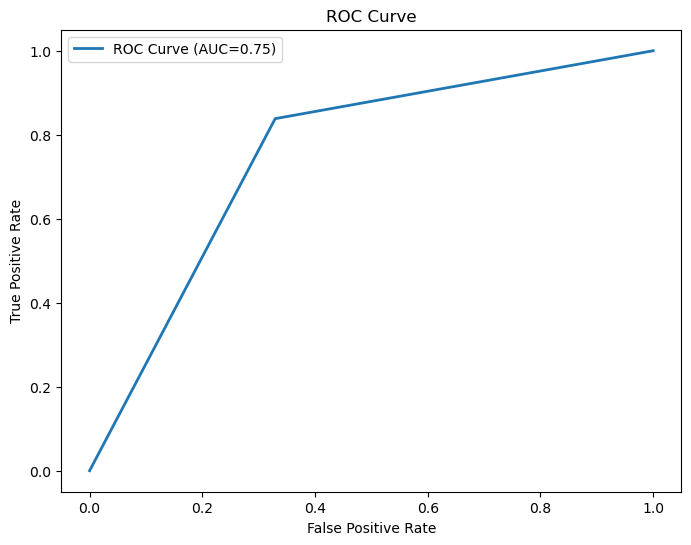

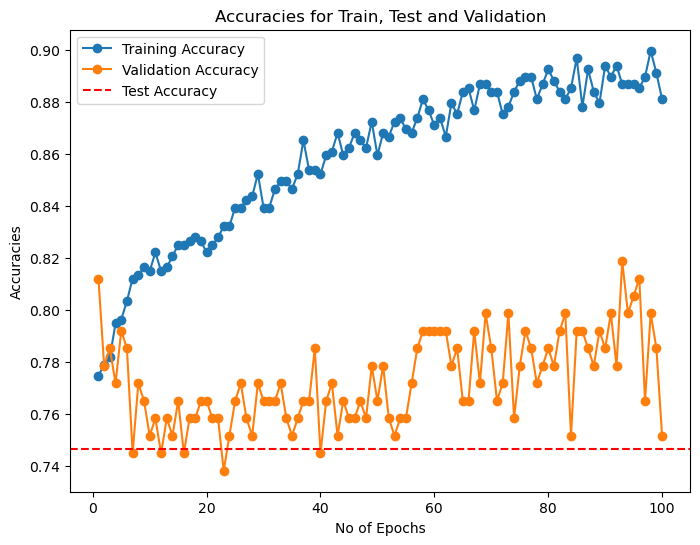

In [625]:
opts = ['Adam','Adamax','RMSProp']
for opt in opts:
    model = TuningNetwork(input_size, hidden_size1, hidden_size2, 0.3)
    if opt == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)

    if opt == 'Adamax':
        optimizer = optim.Adamax(model.parameters(), lr=0.01)

    if opt == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    print()
    print(f"Training with Optimizers : {opt}")
    train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions = trainevalmethod(model, criterion, optimizer)
    print_confusion_matrix(y_test, test_predictions)
    print_loss_graph(train_losses, val_losses)
    print_ROC_Curve(y_test, test_predictions)
    print_accuracy_graph(train_accuracies, val_accuracies)

In [613]:
base_model = TuningNetwork(input_size, hidden_size1, hidden_size2, 0.31818687426066966, 'he')
optimizer = optim.SGD(base_model.parameters(), lr=0.01)
criterion = nn.BCELoss()
print()
print(f"Training with Initializer : he")
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions = trainevalmethod(base_model, criterion, optimizer)


Training with Initializer : he
Time to train model: 1.45 seconds
ROC: 0.77
Test Loss: 0.51
Precision: 0.74
F1 Score: 0.76
Recall: 0.78
Test Accuracy: 77.33%


Early Stopping

In [606]:
num_epochs = 100
batch_size = 32
best_val_accuracy = 0
for epoch in range(num_epochs):
    # Training Step
    base_model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i + batch_size]
        labels = y_train_tensor[i:i + batch_size]

        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

     # Validation Step
    base_model.eval()
    with torch.no_grad():
        val_outputs =  base_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_accuracy = ((val_outputs > 0.5).float() == y_val_tensor).sum().item() / y_val_tensor.size(0)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(accuracy_score(y_train, (base_model(X_train_tensor).detach().numpy() > 0.5).astype(int)))
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}],  Validation Loss: {val_loss.item():.4f}')

    # Saving the model with the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(base_model.state_dict(), 'Early_stopping_model.pth')

# Loading the best model and test
best_early_model = TuningNetwork(input_size, hidden_size1, hidden_size2, 0.3)
best_early_model.load_state_dict(torch.load('Early_stopping_model.pth'))

best_early_model.eval()
with torch.no_grad():
    test_outputs = best_early_model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_predictions = (test_outputs > 0.5).float()
    test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/100],  Validation Loss: 0.4417
Epoch [2/100],  Validation Loss: 0.4419
Epoch [3/100],  Validation Loss: 0.4429
Epoch [4/100],  Validation Loss: 0.4420
Epoch [5/100],  Validation Loss: 0.4432
Epoch [6/100],  Validation Loss: 0.4427
Epoch [7/100],  Validation Loss: 0.4434
Epoch [8/100],  Validation Loss: 0.4434
Epoch [9/100],  Validation Loss: 0.4437
Epoch [10/100],  Validation Loss: 0.4425
Epoch [11/100],  Validation Loss: 0.4430
Epoch [12/100],  Validation Loss: 0.4434
Epoch [13/100],  Validation Loss: 0.4427
Epoch [14/100],  Validation Loss: 0.4435
Epoch [15/100],  Validation Loss: 0.4414
Epoch [16/100],  Validation Loss: 0.4410
Epoch [17/100],  Validation Loss: 0.4398
Epoch [18/100],  Validation Loss: 0.4414
Epoch [19/100],  Validation Loss: 0.4394
Epoch [20/100],  Validation Loss: 0.4400
Epoch [21/100],  Validation Loss: 0.4405
Epoch [22/100],  Validation Loss: 0.4407
Epoch [23/100],  Validation Loss: 0.4405
Epoch [24/100],  Validation Loss: 0.4400
Epoch [25/100],  Validati

Learning rate scheduler

In [607]:
num_epochs = 100
batch_size = 32
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
learning_rates = []
best_val_accuracy = 0
for epoch in range(num_epochs):
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    print(f'-----------Epoch {epoch+1}, Learning Rate: {current_lr}------------')
    # Training Step
    base_model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i + batch_size]
        labels = y_train_tensor[i:i + batch_size]
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

     # Validation Step
    base_model.eval()
    with torch.no_grad():
        val_outputs =  base_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_accuracy = ((val_outputs > 0.5).float() == y_val_tensor).sum().item() / y_val_tensor.size(0)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(accuracy_score(y_train, (base_model(X_train_tensor).detach().numpy() > 0.5).astype(int)))
    val_accuracies.append(val_accuracy)

# Testing Step
base_model.eval()
with torch.no_grad():
    test_outputs = base_model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_predictions = (test_outputs > 0.5).float()
    test_accuracy = accuracy_score(y_test, test_predictions)
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions = trainevalmethod(base_model, criterion, optimizer)

/Users/charankumarnara/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


-----------Epoch 1, Learning Rate: 0.01------------
-----------Epoch 2, Learning Rate: 0.01------------
-----------Epoch 3, Learning Rate: 0.01------------
-----------Epoch 4, Learning Rate: 0.01------------
-----------Epoch 5, Learning Rate: 0.01------------
-----------Epoch 6, Learning Rate: 0.01------------
-----------Epoch 7, Learning Rate: 0.01------------
-----------Epoch 8, Learning Rate: 0.01------------
-----------Epoch 9, Learning Rate: 0.01------------
-----------Epoch 10, Learning Rate: 0.01------------
-----------Epoch 11, Learning Rate: 0.01------------
-----------Epoch 12, Learning Rate: 0.01------------
-----------Epoch 13, Learning Rate: 0.01------------
-----------Epoch 14, Learning Rate: 0.01------------
-----------Epoch 15, Learning Rate: 0.01------------
-----------Epoch 16, Learning Rate: 0.01------------
-----------Epoch 17, Learning Rate: 0.01------------
-----------Epoch 18, Learning Rate: 0.01------------
-----------Epoch 19, Learning Rate: 0.01------------
--

In [608]:
print('Best learning rate: ', learning_rates[-1])

Best learning rate:  1e-05


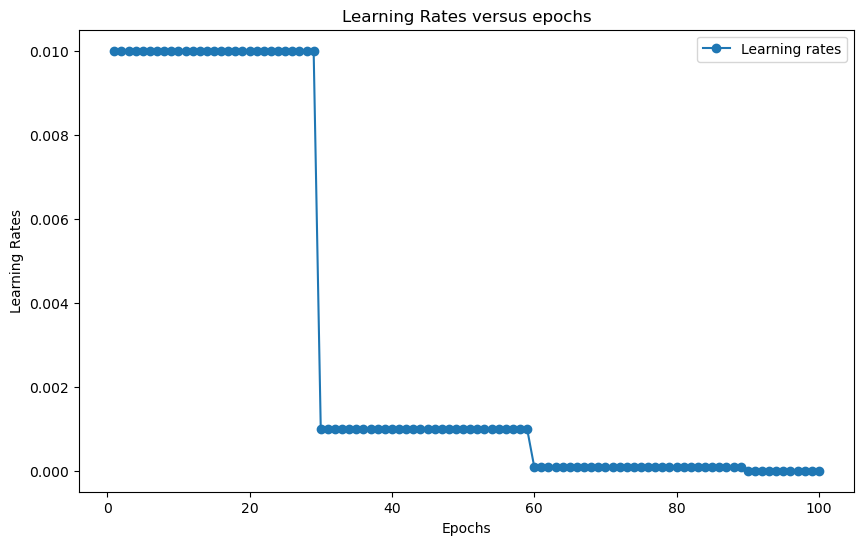

In [627]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, learning_rates, label='Learning rates', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Learning Rates')
plt.title('Learning Rates versus epochs')
plt.legend()

Batch Normalization

In [610]:
# Defining Network
class BatchNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, dropout_rate, initializer_type='default'):
        super(BatchNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1) # USING BATCH NORMALIZATION
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, bias=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2) # USING BATCH NORMALIZATION
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()
        if initializer_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        elif initializer_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        elif initializer_type == 'uniform':
            nn.init.uniform_(self.fc1.weight, -1, 1)
            nn.init.uniform_(self.fc2.weight, -1, 1)
            

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.out(x)
        return self.sigmoid(x)
    
# Instantiate the model
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64

In [615]:
best_batch_model = BatchNN(input_size, hidden_size1, hidden_size2, 0.31818687426066966, 'he')
optimizer = optim.SGD(best_batch_model.parameters(), lr=0.01)
criterion = nn.BCELoss()
print()
print(f"Training with Batch Normalization")
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions = trainevalmethod(best_batch_model, criterion, optimizer)


Training with Batch Normalization
Time to train model: 1.76 seconds
ROC: 0.76
Test Loss: 0.49
Precision: 0.71
F1 Score: 0.75
Recall: 0.79
Test Accuracy: 76.00%


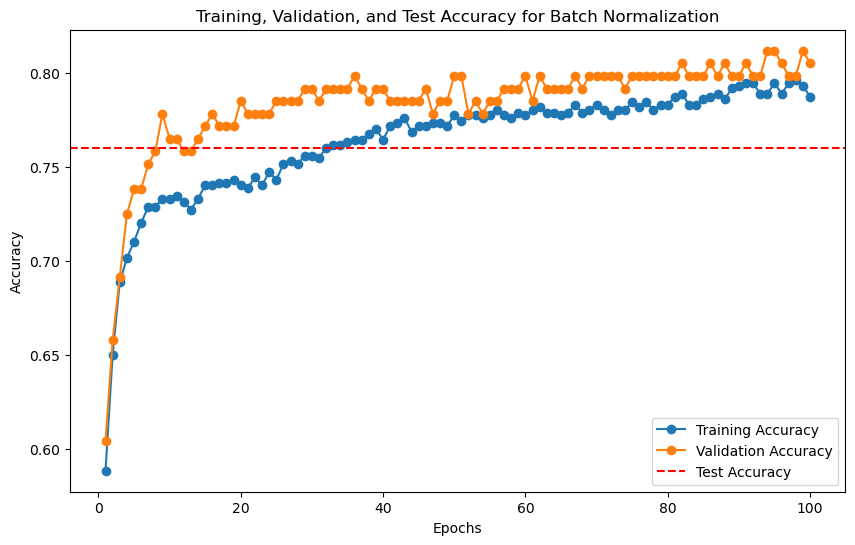

In [616]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy for Batch Normalization')
plt.legend()

L2 Regularization

In [601]:
regularization_model = TuningNetwork(input_size, hidden_size1, hidden_size2, 0.31818687426066966, 'he')
optimizer = optim.SGD(regularization_model.parameters(), lr=0.01, weight_decay=0.000001)
criterion = nn.BCELoss()
print()
print(f"Training with Regularization")
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions = trainevalmethod(regularization_model, criterion, optimizer)


Training with Regularization 
Time to train model: 1.17 seconds
ROC: 0.79
Test Loss: 0.50
Precision: 0.75
F1 Score: 0.77
Recall: 0.79
Test Accuracy: 78.67%


<h4>Choosing the best model as Regularization model and viewing its metrics</h4>

In [630]:
train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy, precision, recall, f1, roc_auc, test_predictions = trainevalmethod(regularization_model, criterion, optimizer)

Time to train model: 1.63 seconds
ROC: 0.79
Test Loss: 0.50
Precision: 0.75
F1 Score: 0.77
Recall: 0.79
Test Accuracy: 78.67%


In [619]:
torch.save(regularization_model.state_dict(), 'cnara_dharmaac_assignment2_part2.h5')

<H2>CONTRIBUTION</H2>
<H4>CHARAN KUMAR NARA: 50 PERCENT</H4>
<H4>DHARMA ACHA: 50 PERCENT</H4>